In [1]:
%load_ext autoreload
%autoreload 2

import numpy  as np
import pandas as pd
import h5py

from tqdm import tqdm
from astropy import units as u
from scipy.interpolate import interp1d

import ehtplot
from matplotlib import pyplot as plt, cm

from common import dalt
from common import hallmark as hm
from common import viz
from common import io_ipole as io

In [16]:
def readsed(f, snapshot=None):

    with h5py.File(f) as h:
        time = h['time'][:]
        nu   = h['nu'  ][:]
        knd  = h['knd' ][:]
        avg  = h['avg' ][:]
      # err  = h['err' ][:]
        rlz  = h['len' ][:]

    if not all(rlz == 16):
        print('WARNING: less than 16 realizations:', f)

    nuLnu = interp1d(time, avg, axis=0)
    
    return time, nu, nuLnu, [k.decode("utf-8") for k in knd]

def Fnu_to_nuLnu(nu, Fnu):
    d = 8.127e3 * u.pc
    S = 4 * np.pi * d * d
    return (Fnu*u.Jy * S * nu*u.Hz).to(u.erg/u.second).value

In [88]:
pf_img  = hm.ParaFrame('model/Illinois_thermal/{freq}/Sa0_w5/img_s05999_Rh40_i50.h5')
pf_summ = hm.ParaFrame('cache/Illinois_thermal_w5/Sa0_i50/summ_Rh40_{freq}.tsv')
pf_sed  = hm.ParaFrame('cache/Illinois_thermal_w5/Sa0_i50/sed_Rh40.h5')

for k in set(pf_img.keys()) - {'path'}:
    globals()[k] = np.unique(pf_img[k])
    print(k, globals()[k][:16])
    
print(pf_img)
print(pf_summ)
print(pf_sed)

freq ['230GHz' '2um' '86GHz' '86GHz-largefov']
                                                path            freq
0  model/Illinois_thermal/230GHz/Sa0_w5/img_s0599...          230GHz
1  model/Illinois_thermal/2um/Sa0_w5/img_s05999_R...             2um
2  model/Illinois_thermal/86GHz-largefov/Sa0_w5/i...  86GHz-largefov
3  model/Illinois_thermal/86GHz/Sa0_w5/img_s05999...           86GHz
                                                path    freq
0  cache/Illinois_thermal_w5/Sa0_i50/summ_Rh40_23...  230GHz
1  cache/Illinois_thermal_w5/Sa0_i50/summ_Rh40_2u...     2um
2  cache/Illinois_thermal_w5/Sa0_i50/summ_Rh40_86...   86GHz
                                            path
0  cache/Illinois_thermal_w5/Sa0_i50/sed_Rh40.h5


In [75]:
pf_img  = hm.ParaFrame('model/Illinois_thermal/{freq}/Sa+0.94_w5/img_s05999_Rh40_i30.h5')
pf_summ = hm.ParaFrame('cache/Illinois_thermal_w5/Sa+0.94_i30/summ_Rh40_{freq}.tsv')
pf_sed  = hm.ParaFrame('cache/Illinois_thermal_w5/Sa+0.94_i30/sed_Rh40.h5')

for k in set(pf_img.keys()) - {'path'}:
    globals()[k] = np.unique(pf_img[k])
    print(k, globals()[k][:16])
    
print(pf_img)
print(pf_summ)
print(pf_sed)

freq ['230GHz' '2um' '86GHz' '86GHz-largefov']
                                                path            freq
0  model/Illinois_thermal/230GHz/Sa+0.94_w5/img_s...          230GHz
1  model/Illinois_thermal/2um/Sa+0.94_w5/img_s059...             2um
2  model/Illinois_thermal/86GHz-largefov/Sa+0.94_...  86GHz-largefov
3  model/Illinois_thermal/86GHz/Sa+0.94_w5/img_s0...           86GHz
                                                path    freq
0  cache/Illinois_thermal_w5/Sa+0.94_i30/summ_Rh4...  230GHz
1  cache/Illinois_thermal_w5/Sa+0.94_i30/summ_Rh4...     2um
2  cache/Illinois_thermal_w5/Sa+0.94_i30/summ_Rh4...   86GHz
                                                path
0  cache/Illinois_thermal_w5/Sa+0.94_i30/sed_Rh40.h5


In [89]:
time, nu, nuLnu, knd = readsed(pf_sed.path.iloc[0])
    
df_86GHz   = pd.read_csv(pf_summ(freq='86GHz' ).path.iloc[0], sep='\t')
df_230GHz  = pd.read_csv(pf_summ(freq='230GHz').path.iloc[0], sep='\t')
df_2um     = pd.read_csv(pf_summ(freq='2um'   ).path.iloc[0], sep='\t')

mov_86GHz  = io.load_mov(pf_img(freq='86GHz' ).path.iloc[0])
mov_230GHz = io.load_mov(pf_img(freq='230GHz').path.iloc[0])
mov_2um    = io.load_mov(pf_img(freq='2um'   ).path.iloc[0])

In [90]:
print(np.max(mov_86GHz))
print(np.max(mov_230GHz))
print(np.max(mov_2um))

0.00011433471233896109 erg / (cm2 Hz s sr)
0.0004317288462778034 erg / (cm2 Hz s sr)
1.8233426950208162e-06 erg / (cm2 Hz s sr)


In [91]:
cmap = cm.get_cmap('afmhot_10us')

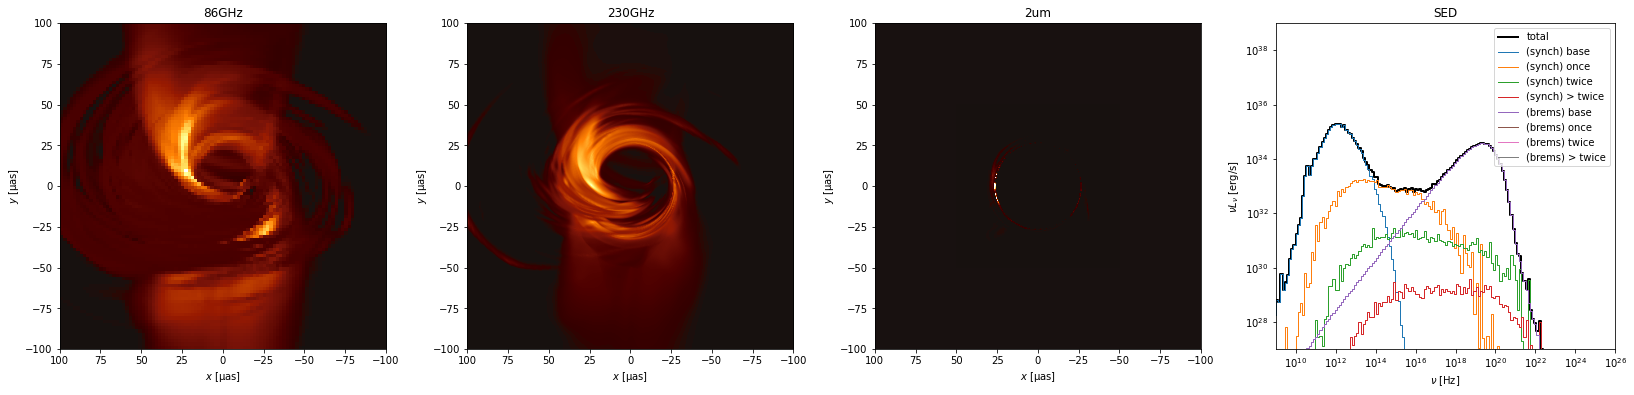

In [92]:
fig, axes = plt.subplots(1, 4, figsize=(28,6))

viz.show(mov_86GHz,  s=0, ax=axes[0], cmap=cmap, vmin=0)
axes[0].set_xlim( 100, -100)
axes[0].set_ylim(-100,  100)
axes[0].set_title('86GHz')

viz.show(mov_230GHz, s=0, ax=axes[1], cmap=cmap, vmin=0)
axes[1].set_xlim( 100, -100)
axes[1].set_ylim(-100,  100)
axes[1].set_title('230GHz')

viz.show(mov_2um,    s=0, ax=axes[2], cmap=cmap, vmin=0, vmax=5e-7)
axes[2].set_facecolor(cmap(0))
axes[2].set_xlim( 100, -100)
axes[2].set_ylim(-100,  100)
axes[2].set_title('2um')

viz.step(axes[3], nu, nuLnu(time[-1]), label=knd)
axes[3].set_xlim(1e9,  1e26)
axes[3].set_ylim(1e27, 1e39)
axes[3].set_xlabel(r'$\nu$ [Hz]')
axes[3].set_ylabel(r'$\nu L_\nu$ [erg/s]')
axes[3].legend(loc='upper right')
axes[3].set_title('SED')

fig.savefig('snapshot_Sa+0.94_Rh40_i30.png', dpi=300)